In [77]:
#!/bin/python 
import tensorflow as tf 

from keras.applications.resnet50 import ResNet50
import numpy as np
import matplotlib.pyplot as plt
# from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Input, Flatten, Dropout, Activation, Lambda, RepeatVector
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import concatenate
from keras.engine.topology import Layer
from keras.layers.wrappers import TimeDistributed
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects
import keras.utils
from keras.optimizers import SGD
from keras.optimizers import Adam
from tensorflow.contrib import distributions
#from bnn.loss_equations import bayesian_categorical_crossentropy
from Datas import Initialize_data,ComputeAccuracy,Draw_loss,unpickle
(trx,trY,trsy,valx,valY,valy,testx,testY,testy) = Initialize_data(1) 

In [174]:
def label_con(num):
    
    num = int(num)
 
    if num == 0:
        return 'airplane'
    elif num == 1 :
        return 'automobile'
    elif num == 2 :
        return 'bird'
    elif num == 3 :
        return 'cat'
    elif num == 4 :
        name = 'deer'
    elif num == 5 :
        return 'dog'
    elif num == 6 :
        return 'frog'
    elif num == 7 :
        return 'horse'
    elif num == 8 :
        return 'ship'
    elif num == 9 :
        return 'truck'
    else:
        return 'wrong'
    
        
        
        
        
        

In [372]:
def merge_ale_epi(ale,epi):
    temp1 = np.sqrt(np.exp(np.log(ale**2)))
    temp2 = np.sqrt(np.exp(np.log(epi**2)))
    
    return temp1 + temp2

In [312]:

class TimeDistributedMean(Layer):
	def build(self, input_shape):
		super(TimeDistributedMean, self).build(input_shape)

	# input shape (None, T, ...)
	# output shape (None, ...)
	def compute_output_shape(self, input_shape):
		return (input_shape[0],) + input_shape[2:]

	def call(self, x):
		return K.mean(x, axis=1)


class PredictiveEntropy(Layer):
	def build(self, input_shape):
		super(PredictiveEntropy, self).build(input_shape)

	# input shape (None, C, ...)
	# output shape (None, ...)
	def compute_output_shape(self, input_shape):
		return (input_shape[0],)

	# x - prediction probability for each class(C)
	def call(self, x):
		return -1 * K.sum(K.log(x) * x, axis=1)

In [ ]:
from keras.callbacks import *

class CyclicLR(Callback):
    
    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())

In [311]:
def montecarlo_prediction(model, X_data, T):
	# shape: (T, N, C)
	predictions = np.array([model.predict(X_data) for _ in range(T)])

	# shape: (N, C)
	prediction_probabilities = np.mean(predictions, axis=0)
	
	# shape: (N)
	prediction_variances = np.apply_along_axis(predictive_entropy, axis=1, arr=prediction_probabilities)
	return (prediction_probabilities, prediction_variances)

In [370]:
# prob - prediction probability for each class(C). Shape: (N, C)
# returns - Shape: (N)
def predictive_entropy(pred):
    #### for each class
    return -1 * np.sum(np.log(pred) * pred, axis=1)
def montecarlo_prediction(model, X_data, T):
	# shape: (T, N, C)
    predictions = []
    for _ in range(T):
        (logit,predict) = model.predict(X_data)
        predictions.append(predict)
    predictions = np.array(predictions)
# predictions = np.array([model.predict(X_data) for _ in range(T)])

    # shape: (N, C)
    prediction_probabilities = np.mean(predictions, axis=0)
    
    # shape: (N)
    prediction_variances  = np.var(prediction_probabilities,axis=1)
    return (prediction_probabilities, prediction_variances)





def categorical_cross_entropy(true, pred):
	return -np.sum(true * np.log(pred), axis=1)

def bayesian_categorical_crossentropy(T, num_classes):
    def bayesian_categorical_crossentropy_internal(true, pred_var):
    # shape: (N,)
        std = K.sqrt(pred_var[:, num_classes:])
    # shape: (N,)
        variance = pred_var[:, num_classes]
        variance_depressor = K.exp(variance) - K.ones_like(variance)
    # shape: (N, C)
        pred = pred_var[:, 0:num_classes]
    # shape: (N,)
        undistorted_loss = K.categorical_crossentropy(pred, true, from_logits=True)
    # shape: (T,)
        iterable = K.variable(np.ones(T))
        dist = distributions.Normal(loc=K.zeros_like(std), scale=std)
        monte_carlo_results = K.map_fn(gaussian_categorical_crossentropy(true, pred, dist, undistorted_loss, num_classes), iterable, name='monte_carlo_results')
    
        variance_loss = K.mean(monte_carlo_results, axis=0) * undistorted_loss
    
        return variance_loss + undistorted_loss + variance_depressor
  
    return bayesian_categorical_crossentropy_internal


def gaussian_categorical_crossentropy(true, pred, dist, undistorted_loss, num_classes):
    def map_fn(i):
        std_samples = K.transpose(dist.sample(num_classes))
        distorted_loss = K.categorical_crossentropy(pred + std_samples, true, from_logits=True)
        diff = undistorted_loss - distorted_loss
        return -K.elu(diff)
    return map_fn

## Build the model
### We use 3 layer neural network to build the model.

In [ ]:
(trx,trY,trsy,valx,valY,valy,testx,testY,testy) = Initialize_data(1)  

def Build_Model(Batch_size,Epoch):
    from keras import regularizers
    rate = 0.18
    Inputs = Input(shape=(3072,))
    x = BatchNormalization()(Inputs)
    x = Dense(200, activation="relu",kernel_initializer = 'RandomNormal',bias_initializer = 'zeros')(x)#,kernel_regularizer=regularizers.l2(0.0001),activity_regularizer=regularizers.l1(0.0001))(x)
    x = BatchNormalization()(x)
    x = Dropout(rate,noise_shape=None, seed=None)(x,training = True)
    x = Dense(100, activation="relu",kernel_initializer = 'RandomNormal',bias_initializer = 'zeros')(x)#,kernel_regularizer=regularizers.l2(0.0001),activity_regularizer=regularizers.l1(0.0001))(x)
    x = BatchNormalization()(x)
    x = Dropout(rate,noise_shape=None, seed=None)(x,training=True)
    x = Dense(50, activation="relu",kernel_initializer = 'RandomNormal',bias_initializer = 'zeros')(x)#,kernel_regularizer=regularizers.l2(0.0001),activity_regularizer=regularizers.l1(0.0001))(x)
    x = BatchNormalization()(x)
    x = Dropout(rate,noise_shape=None, seed=None)(x)
    logits = Dense(10)(x)
    variance_pre = Dense(1)(x)
    variance = Activation('softplus', name='variance')(variance_pre)
    logits_variance = concatenate([logits, variance], name='logits_variance')
    softmax_output = Activation('softmax', name='softmax_output')(logits)
    
    model = Model(inputs= Inputs, outputs=[logits_variance,softmax_output])

    return model



Batch_size =  200
Epoch = 20
model = Build_Model(Batch_size,Epoch)
INIT_LR = 0.001
opt = SGD(lr = INIT_LR,decay=0.001)
opt1 = Adam(lr=1e-5)
model.compile(optimizer = opt1,
loss={'logits_variance': bayesian_categorical_crossentropy(1000, 10),
       'softmax_output': 'categorical_crossentropy'},
        metrics=["accuracy"],
        loss_weights={'logits_variance': .3, 'softmax_output': 1.3})

    #### model fit
iterations = 3
step_size = round(len(trsy)*Epoch/16)
base_lr = 0.00002
max_lr = 0.0001
cycle = np.floor(1+iterations/(2*step_size))
x = np.abs(iterations/step_size - 2*cycle + 1)
lr = base_lr + (max_lr-base_lr)*np.maximum(0, (1-x))/float(2**(cycle-1))
H = model.fit(trx, [trY,trY], validation_data=(valx, [valY,valY]),
                    epochs = Epoch, batch_size = Batch_size,callbacks=[clr])
    #### model predict

#logits,predictions = model.predict(testx, batch_size = Batch_size)




Train on 48999 samples, validate on 999 samples
Epoch 1/20
  600/48999 [..............................] - ETA: 4:20 - loss: 4.7852 - logits_variance_loss: 3.1224 - softmax_output_loss: 2.9604 - logits_variance_acc: 0.1267 - softmax_output_acc: 0.1433

/anaconda3/lib/python3.7/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.538961). Check your callbacks.
  % delta_t_median)


48999/48999 [==============================] - 35s 711us/step - loss: 2.5129 - logits_variance_loss: 0.5394 - softmax_output_loss: 1.8086 - logits_variance_acc: 0.3553 - softmax_output_acc: 0.3568 - val_loss: 2.1283 - val_logits_variance_loss: 0.2351 - val_softmax_output_loss: 1.5829 - val_logits_variance_acc: 0.4274 - val_softmax_output_acc: 0.4274
Epoch 2/20
35400/48999 [====================>.........] - ETA: 8s - loss: 2.0417 - logits_variance_loss: -0.0142 - softmax_output_loss: 1.5738 - logits_variance_acc: 0.4377 - softmax_output_acc: 0.4378

# Predict the model with the test data 
## to test the model with test data and compute the accuracy

In [398]:
logit,predictions = model.predict(testx, batch_size = Batch_size)

# T = 100
# (prediction_probabilities, prediction_variances) = montecarlo_prediction(model, testx, T)
# # print(prediction_probabilities)
# # print(prediction_variances)
print('accuracy in test data')
print(ComputeAccuracy(predictions,testy))



accuracy in test data
0.493


# Draw the loss

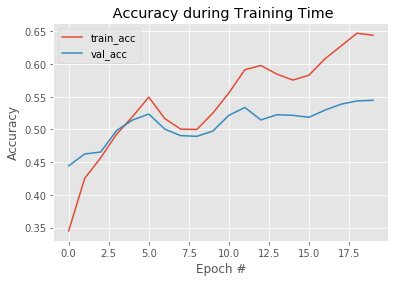

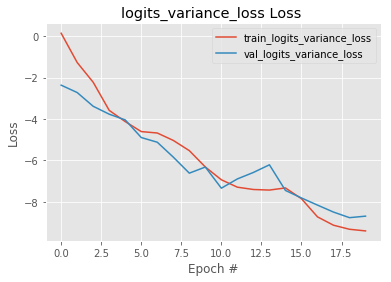

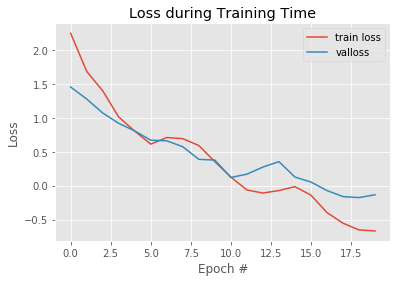

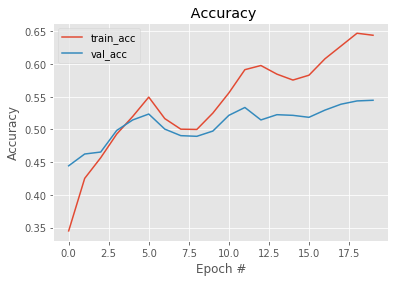

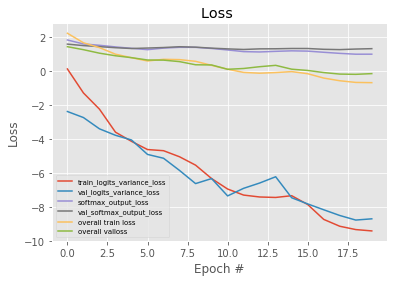

<Figure size 432x288 with 0 Axes>

In [388]:
def Draw_loss(epochs,predictions,H):
    N = np.arange(0, epochs)
    plt.style.use("ggplot")
    #### print accuracy
    plt.figure()
    plt.plot(N, H.history["softmax_output_acc"], label="train_acc")
    plt.plot(N, H.history["val_softmax_output_acc"], label="val_acc")
    plt.title(" Accuracy during Training Time")
    plt.xlabel("Epoch #")
    plt.ylabel("Accuracy")
    plt.legend()
    #### print loss
    plt.figure()
    plt.plot(N, H.history["logits_variance_loss"], label="train_logits_variance_loss")
    plt.plot(N, H.history["val_logits_variance_loss"], label="val_logits_variance_loss")
    plt.title("logits_variance_loss Loss ")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend()
    
    plt.figure()
    plt.plot(N, H.history["loss"], label="train loss")
    plt.plot(N, H.history["val_loss"], label="valloss")
    plt.title("Loss during Training Time")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend()
def Draw_loss_advanced(epochs,predictions,H):
    N = np.arange(0, epochs)
    plt.style.use("ggplot")
    #### print accuracy
    plt.figure()
    plt.plot(N, H.history["softmax_output_acc"], label="train_acc")
    plt.plot(N, H.history["val_softmax_output_acc"], label="val_acc")
    plt.title(" Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Accuracy")
    plt.legend()
    #### print loss
    plt.figure()
    plt.plot(N, H.history["logits_variance_loss"], label="train_logits_variance_loss")
    plt.plot(N, H.history["val_logits_variance_loss"], label="val_logits_variance_loss")
    plt.plot(N, H.history["softmax_output_loss"],label="softmax_output_loss")
    plt.plot(N, H.history["val_softmax_output_loss"],label="val_softmax_output_loss")
    plt.plot(N, H.history["loss"], label="overall train loss")
    plt.plot(N, H.history["val_loss"], label="overall valloss")
    plt.title("Loss ")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend(fontsize='x-small',loc=3)
    
    plt.figure()
Draw_loss(Epoch,predictions,H)   
Draw_loss_advanced(Epoch,predictions,H)   

# Plot the plot
### -> logits vs. loss
### -> aleatoric uncertainty vs. entropy
### -> epistemic uncertainty vs. entropy
### then return a dataframe about the image information

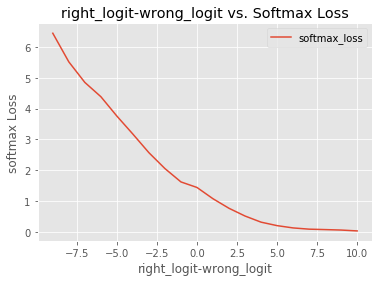

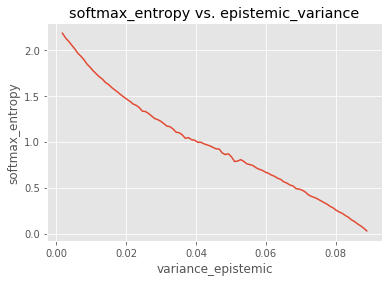

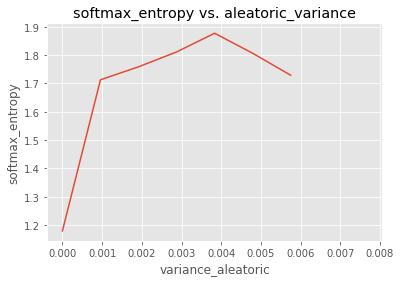

In [391]:
def print_logit_diff(logitx,testY,predictions,episvariance):
    (D,h)                     = testY.shape
    logit                     = logitx[:,0:10]
    a_variance                = logitx[:,10]
    estimated_answer          = predictions.argmax(axis=1)
    true_answer               = testY.argmax(axis = 1)
    foo                       = range(D)
    wrong_logit               = np.array(logit[foo,estimated_answer])
    right_logit               = np.array(logit[foo,true_answer])
    w_minus_r                 = right_logit - wrong_logit
    w_minus_r[w_minus_r == 0] = right_logit[w_minus_r==0]
    softmax_loss              = categorical_cross_entropy(testY, predictions) 
    softmax_loss              = np.array(softmax_loss)
    softmax_entropy           = predictive_entropy(predictions)
    import pandas as pd
    data = {'w_minus_r':w_minus_r,'softmax_entropy':softmax_entropy,'softmax_loss':softmax_loss,'estimated_answer': estimated_answer,
            'true_answer':true_answer,'variance_aleatoric':a_variance,'variance_epistemic':episvariance}
    df = pd.DataFrame(data)
    df = df.sort_values(by='w_minus_r')
#     print(df)
    average_wr(df)
    softmax_entropy_var_epistemic(df)
    softmax_entropy_var_aleatoric(df)

    return df
def average_wr(df):
    min_x = int(min(df['w_minus_r']))
    max_x = int(max(df['w_minus_r']))
#     print(min_x)
#     print(max_x)
    temp_x = []
    temp_y = []
    for i in range(min_x,max_x-1):
        cond_a = df['w_minus_r'] > i 
        cond_b = df['w_minus_r'] < i+1
        temp_df = df[cond_a & cond_b]
        temp_list = reject_outliers(temp_df['variance_epistemic'])
        ave_loss = np.mean(temp_list)
        ave_loss = np.mean(temp_df['softmax_loss'])
        temp_x.append(i)
        temp_y.append(ave_loss)
        
    plt.figure()
    plt.plot(temp_x, temp_y, label="softmax_loss")
    plt.title("right_logit-wrong_logit vs. Softmax Loss")
    plt.xlabel("right_logit-wrong_logit")
    plt.ylabel("softmax Loss")
    plt.legend()
    
##### see if softmax_entropic and epistemic var relationship ->  var should decrease
def softmax_entropy_var_epistemic(df):
    sort_df = df.sort_values(by='softmax_entropy')
#     print(sort_df)
    min_x = min(df['variance_epistemic'])
    max_x = max(df['variance_epistemic'])
#     if max_x > 1:
#         max_x = max(df['variance_epistemic'])-1
    ind   = (max_x - min_x)/100
    temp_x = []
    temp_y = []
    for i in range(100):
        dx = min_x + i*ind
        cond_a = df['variance_epistemic'] > dx
        cond_b = df['variance_epistemic'] < dx+ind
        #### wrong or not
#         cond_c = df['w_minus_r'] >= 0
        temp_df = df[cond_a & cond_b]
        temp_list = reject_outliers(temp_df['softmax_entropy'])
        ave_entropy = np.mean(temp_list)
#         ave_entropy = np.mean(temp_df['softmax_entropy'])
        temp_x.append(dx)
        temp_y.append(ave_entropy)
    plt.figure()
    plt.plot(temp_x, temp_y)
    plt.title("softmax_entropy vs. epistemic_variance")
    plt.xlabel("variance_epistemic")
    plt.ylabel("softmax_entropy")
#######################################
def softmax_entropy_var_aleatoric(df):
    sort_df = df.sort_values(by='softmax_entropy')
    min_x = min(df['variance_aleatoric']) 
    max_x = max(df['variance_aleatoric'])
    ind   = (max_x - min_x)/10
    temp_x = []
    temp_y = []
#     print(ind)
    for i in range(10):
        dx = min_x + i*ind
        cond_a = df['variance_aleatoric'] > dx
        cond_b = df['variance_aleatoric'] < dx+ind
        #### wrong or not
#         cond_c = df['w_minus_r'] >= 0
        
        temp_df = df[cond_a & cond_b]
        temp_list = reject_outliers(temp_df['softmax_entropy'])
        ave_entropy = np.mean(temp_df['softmax_entropy'])
        temp_x.append(dx)
        temp_y.append(ave_entropy)
    plt.figure()
    plt.plot(temp_x, temp_y)
    plt.title("softmax_entropy vs. aleatoric_variance")
    plt.xlabel("variance_aleatoric")
    plt.ylabel("softmax_entropy")

#     ax = plt.gca()
#     df.plot(kind='line',x='variance_epistemic',y='softmax_entropy',ax=ax)
        
    
def reject_outliers(data):
    m = 2
    u = np.mean(data)
    s = np.std(data)
    filtered = [e for e in data if ( e < u + 3 * s)]
    return filtered


# prediction_probabilities,prediction_variances= montecarlo_prediction(model, testx, 100)
# logits,predictions = model.predict(testx, batch_size = Batch_size)
dataframe = print_logit_diff(logits,testY,prediction_probabilities,prediction_variances)


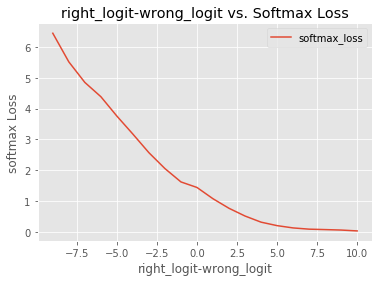

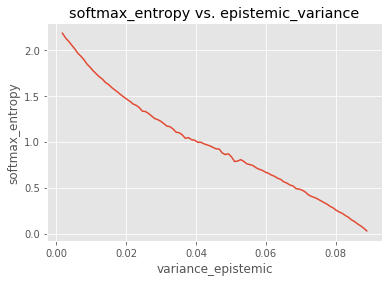

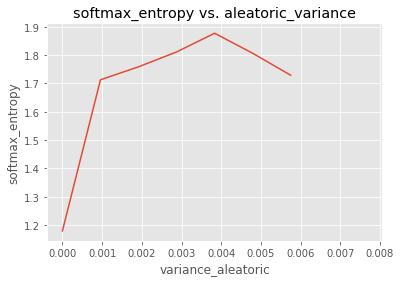

In [392]:
dataframe = print_logit_diff(logits,testY,prediction_probabilities,prediction_variances)
dataframe['confidence_error'] = merge_ale_epi(dataframe['variance_aleatoric'],dataframe['variance_epistemic'])
# dataframe['accuracy'] = 
dataframe['confidence'] = prediction_probabilities.max(axis=1)
# print(dataframe)

## Plot the result

In [393]:
sort_loss = dataframe.sort_values(by='softmax_loss',ascending = 0)
index_mostloss = sort_loss.index
sort_ale = dataframe.sort_values(by = 'variance_aleatoric',ascending = 0)
index_mostale = sort_ale.index
sort_epi = dataframe.sort_values(by = 'variance_epistemic',ascending = 0)
index_mostepi = sort_epi.index

# sort_loss['image'] = plt.imshow()

<Figure size 432x288 with 0 Axes>

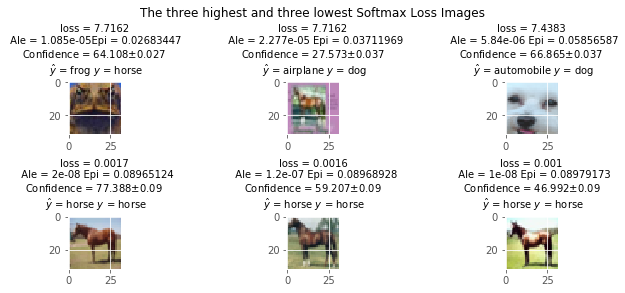

In [394]:
train = unpickle('test_batch')

X = train[b'data']

X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("uint8")
##### loss
fig = plt.figure()
fig, axes = plt.subplots(2,3, constrained_layout=True, figsize=(9,4))
plt.suptitle('The three highest and three lowest Softmax Loss Images')
# ax1 = fig.add_subplot(211)
# ax2 = fig.add_subplot(212)
# ax3 = fig.add_subplot(233)
# ax4 = fig.add_subplot(234)
# ax5 = fig.add_subplot(235)
# ax6 = fig.add_subplot(236)
axes[0,0].set_title('loss = ' 
                   + str(round(sort_loss.loc[index_mostloss[1]]['softmax_loss'] , 4)) 
                   + '\n'
#                    + 'uncerntainty = ' + str(round(merge_ale_epi(sort_loss.loc[index_mostloss[0]]['variance_aleatoric'],sort_loss.loc[index_mostloss[0]]['variance_epistemic']),6))
                   +' Ale = '+ str(round(sort_loss.loc[index_mostloss[1]]['variance_aleatoric'],8))
                   + 'Epi = '+ str(round(sort_loss.loc[index_mostloss[1]]['variance_epistemic'],8))
                   + '\n'
                   + 'Confidence = ' + str(round(sort_loss.loc[index_mostloss[1]]['confidence']*100,3))+'$\pm$'+str(round(sort_loss.loc[index_mostloss[1]]['confidence_error'],3))
                   + '\n'
                   + ' $\hat{y}$ = ' + str(label_con(sort_loss.loc[index_mostloss[1]]['estimated_answer']))
                   + ' $y$ = ' + str(label_con(sort_loss.loc[index_mostloss[1]]['true_answer'])), fontdict={'fontsize': 10})
         
axes[0,1].set_title('loss = ' 
                   + str(round(sort_loss.loc[index_mostloss[1]]['softmax_loss'] , 4)) 
                   + '\n'
#                    +  'uncerntainty = ' + str(round(merge_ale_epi(sort_loss.loc[index_mostloss[1]]['variance_aleatoric'],sort_loss.loc[index_mostloss[1]]['variance_epistemic']),6))
                   +'  Ale = '+ str(round(sort_loss.loc[index_mostloss[2]]['variance_aleatoric'],8))
                   + ' Epi = '+ str(round(sort_loss.loc[index_mostloss[2]]['variance_epistemic'],8))
                   + '\n'
                   + 'Confidence = ' + str(round(sort_loss.loc[index_mostloss[2]]['confidence']*100,3))+'$\pm$'+str(round(sort_loss.loc[index_mostloss[2]]['confidence_error'],3))
                   + '\n'
                   + ' $\hat{y}$ = ' + str(label_con(sort_loss.loc[index_mostloss[2]]['estimated_answer']))
                   + ' $y$ = ' + str(label_con(sort_loss.loc[index_mostloss[2]]['true_answer'])), fontdict={'fontsize': 10})
axes[0,2].set_title('loss = ' 
                   + str(round(sort_loss.loc[index_mostloss[2]]['softmax_loss'] , 4)) 
                   + '\n'
#                    + 'uncerntainty = ' + str(round(merge_ale_epi(sort_loss.loc[index_mostloss[2]]['variance_aleatoric'],sort_loss.loc[index_mostloss[2]]['variance_epistemic']),6))
                   +'  Ale = '+ str(round(sort_loss.loc[index_mostloss[3]]['variance_aleatoric'],8))
                   + ' Epi = '+ str(round(sort_loss.loc[index_mostloss[3]]['variance_epistemic'],8))
                   + '\n'
                   + 'Confidence = ' + str(round(sort_loss.loc[index_mostloss[3]]['confidence']*100,3))+'$\pm$'+str(round(sort_loss.loc[index_mostloss[2]]['confidence_error'],3))
                   + '\n'
                   + ' $\hat{y}$ = ' + str(label_con(sort_loss.loc[index_mostloss[3]]['estimated_answer']))
                   + ' $y$ = ' + str(label_con(sort_loss.loc[index_mostloss[3]]['true_answer'])), fontdict={'fontsize': 10})
axes[1,0].set_title('loss = ' 
                   + str(round(sort_loss.loc[index_mostloss[-3]]['softmax_loss'] , 4)) 
                   + '\n'
#                    +  'uncerntainty = ' + str(round(merge_ale_epi(sort_loss.loc[index_mostloss[3]]['variance_aleatoric'],sort_loss.loc[index_mostloss[3]]['variance_epistemic']),6))
                   +'  Ale = '+ str(round(sort_loss.loc[index_mostloss[-3]]['variance_aleatoric'],8))
                   + ' Epi = '+ str(round(sort_loss.loc[index_mostloss[-3]]['variance_epistemic'],8))
                   + '\n'
                   + 'Confidence = ' + str(round(sort_loss.loc[index_mostloss[-3]]['confidence']*100,3))+'$\pm$'+str(round(sort_loss.loc[index_mostloss[-3]]['confidence_error'],3))
                   + '\n'
                   + ' $\hat{y}$ = ' + str(label_con(sort_loss.loc[index_mostloss[-3]]['estimated_answer']))
                   + ' $y$ = ' + str(label_con(sort_loss.loc[index_mostloss[-3]]['true_answer'])), fontdict={'fontsize': 10})
axes[1,1].set_title('loss = ' 
                   + str(round(sort_loss.loc[index_mostloss[-2]]['softmax_loss'] , 4)) 
                   + '\n'
#                    + 'uncerntainty = ' + str(round(merge_ale_epi(sort_loss.loc[index_mostloss[4]]['variance_aleatoric'],sort_loss.loc[index_mostloss[4]]['variance_epistemic']),6)) 
                   +'  Ale = '+ str(round(sort_loss.loc[index_mostloss[-2]]['variance_aleatoric'],8))
                   + ' Epi = '+ str(round(sort_loss.loc[index_mostloss[-2]]['variance_epistemic'],8))
                   + '\n'
                   + 'Confidence = ' + str(round(sort_loss.loc[index_mostloss[-2]]['confidence']*100,3))+'$\pm$'+str(round(sort_loss.loc[index_mostloss[-2]]['confidence_error'],3))
                   + '\n'
                   + ' $\hat{y}$ = ' + str(label_con(sort_loss.loc[index_mostloss[-2]]['estimated_answer']))
                   + ' $y$ = ' + str(label_con(sort_loss.loc[index_mostloss[-2]]['true_answer'])), fontdict={'fontsize': 10})
axes[1,2].set_title('loss = ' 
                   + str(round(sort_loss.loc[index_mostloss[-1]]['softmax_loss'] , 4)) 
                   + '\n'
#                    + 'uncerntainty = ' + str(round(merge_ale_epi(sort_loss.loc[index_mostloss[5]]['variance_aleatoric'],sort_loss.loc[index_mostloss[5]]['variance_epistemic']),6))
                   +'  Ale = '+ str(round(sort_loss.loc[index_mostloss[-1]]['variance_aleatoric'],8))
                   + ' Epi = '+ str(round(sort_loss.loc[index_mostloss[-1]]['variance_epistemic'],8))
                   + '\n'
                   + 'Confidence = ' + str(round(sort_loss.loc[index_mostloss[-1]]['confidence']*100,3))+'$\pm$'+str(round(sort_loss.loc[index_mostloss[-1]]['confidence_error'],3))
                   + '\n'
                   + ' $\hat{y}$ = ' + str(label_con(sort_loss.loc[index_mostloss[-1]]['estimated_answer']))
                   + ' $y$ = ' + str(label_con(sort_loss.loc[index_mostloss[-1]]['true_answer'])), fontdict={'fontsize': 10})


axes[0,0].imshow(X[index_mostloss[0]],interpolation='nearest')

axes[0,1].imshow(X[index_mostloss[1]],interpolation='nearest')
# set(axes[1], 'FontSize', 8)
axes[0,2].imshow(X[index_mostloss[2]],interpolation='nearest')
# set(axes[2], 'FontSize', 8)
axes[1,0].imshow(X[index_mostloss[-3]],interpolation='nearest')
# set(axes[3], 'FontSize', 8)
axes[1,1].imshow(X[index_mostloss[-2]],interpolation='nearest')
# set(axes[4], 'FontSize', 8)
axes[1,2].imshow(X[index_mostloss[-1]],interpolation='nearest')
# set(axes[5], 'FontSize', 8)
# ax3.title.set_text('Third Plot')
# ax4.title.set_text('Fourth Plot')
plt.show()
# a = sort_loss.loc[index_mostloss[1]]['estimated_answer']
# print(sort_loss.loc[index_mostloss[1]]['estimated_answer'])
# print(label_con(a))
# print(a==7)

<Figure size 432x288 with 0 Axes>

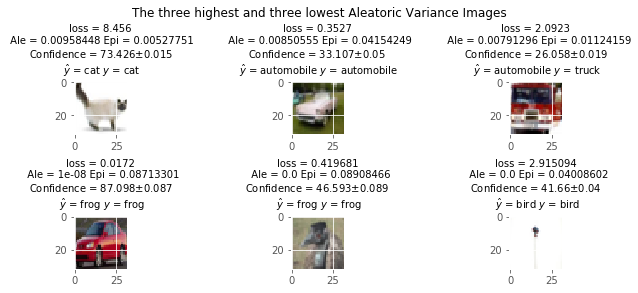

In [395]:
fig = plt.figure()
fig, axes = plt.subplots(2,3, constrained_layout=True, figsize=(9,4))
plt.suptitle('The three highest and three lowest Aleatoric Variance Images')
# ax1 = fig.add_subplot(211)
# ax2 = fig.add_subplot(212)
# ax3 = fig.add_subplot(233)
# ax4 = fig.add_subplot(234)
# ax5 = fig.add_subplot(235)
# ax6 = fig.add_subplot(236)
axes[0,0].set_title('loss = ' 
                   + str(round(sort_ale.loc[index_mostloss[0]]['softmax_loss'] , 4)) 
                   + '\n'
#                    + 'uncerntainty = ' + str(round(merge_ale_epi(sort_ale.loc[index_mostale[0]]['variance_aleatoric'],sort_ale.loc[index_mostale[0]]['variance_epistemic']),6))
                   +' Ale = '+ str(round(sort_ale.loc[index_mostale[0]]['variance_aleatoric'],8))
                   + ' Epi = '+ str(round(sort_ale.loc[index_mostale[0]]['variance_epistemic'],8))
                   + '\n'
                   + 'Confidence = ' + str(round(sort_ale.loc[index_mostale[0]]['confidence']*100,3))+'$\pm$'+str(round(sort_ale.loc[index_mostale[0]]['confidence_error'],3))
                   + '\n'
                   + ' $\hat{y}$ = ' + str(label_con(sort_ale.loc[index_mostale[0]]['estimated_answer']))
                   + ' $y$ = ' + str(label_con(sort_ale.loc[index_mostale[0]]['true_answer'])), fontdict={'fontsize': 10})
         
axes[0,1].set_title('loss = ' 
                   + str(round(sort_ale.loc[index_mostale[1]]['softmax_loss'] , 4)) 
                   + '\n'
#                    + 'uncerntainty = ' + str(round(merge_ale_epi(sort_ale.loc[index_mostale[1]]['variance_aleatoric'],sort_ale.loc[index_mostale[1]]['variance_epistemic']),6))
                   +'  Ale = '+ str(round(sort_ale.loc[index_mostale[1]]['variance_aleatoric'],8))
                   + ' Epi = '+ str(round(sort_ale.loc[index_mostale[1]]['variance_epistemic'],8))
                   + '\n'
                   + 'Confidence = ' + str(round(sort_ale.loc[index_mostale[1]]['confidence']*100,3))+'$\pm$'+str(round(sort_ale.loc[index_mostale[1]]['confidence_error'],3))
                   + '\n'
                   + ' $\hat{y}$ = ' + str(label_con(sort_ale.loc[index_mostale[1]]['estimated_answer']))
                   + ' $y$ = ' + str(label_con(sort_ale.loc[index_mostale[1]]['true_answer'])), fontdict={'fontsize': 10})
axes[0,2].set_title('loss = ' 
                   + str(round(sort_ale.loc[index_mostale[2]]['softmax_loss'] , 4)) 
                   + '\n'
#                    + 'uncerntainty = ' + str(round(merge_ale_epi(sort_ale.loc[index_mostale[2]]['variance_aleatoric'],sort_ale.loc[index_mostale[2]]['variance_epistemic']),6))
                   +'  Ale = '+ str(round(sort_ale.loc[index_mostale[2]]['variance_aleatoric'],8))
                   + ' Epi = '+ str(round(sort_ale.loc[index_mostale[2]]['variance_epistemic'],8))
                   + '\n'
                   + 'Confidence = ' + str(round(sort_ale.loc[index_mostale[2]]['confidence']*100,3))+'$\pm$'+str(round(sort_ale.loc[index_mostale[2]]['confidence_error'],3))
                   + '\n'
                   + ' $\hat{y}$ = ' + str(label_con(sort_ale.loc[index_mostale[2]]['estimated_answer']))
                   + ' $y$ = ' + str(label_con(sort_ale.loc[index_mostale[2]]['true_answer'])), fontdict={'fontsize': 10})
axes[1,0].set_title('loss = ' 
                   + str(round(sort_ale.loc[index_mostale[-3]]['softmax_loss'] , 4)) 
                   + '\n'
#                    + 'uncerntainty = ' + str(round(merge_ale_epi(sort_ale.loc[index_mostale[3]]['variance_aleatoric'],sort_ale.loc[index_mostale[3]]['variance_epistemic']),6))
                   +'  Ale = '+ str(round(sort_ale.loc[index_mostale[-5]]['variance_aleatoric'],8))
                   + ' Epi = '+ str(round(sort_ale.loc[index_mostale[-5]]['variance_epistemic'],8))
                   + '\n'
                   + 'Confidence = ' + str(round(sort_ale.loc[index_mostale[-5]]['confidence']*100,3))+'$\pm$'+str(round(sort_ale.loc[index_mostale[-5]]['confidence_error'],3))
                   + '\n'
                   + ' $\hat{y}$ = ' + str(label_con(sort_ale.loc[index_mostale[-5]]['estimated_answer']))
                   + ' $y$ = ' + str(label_con(sort_ale.loc[index_mostale[-5]]['true_answer'])), fontdict={'fontsize': 10})
axes[1,1].set_title('loss = ' 
                   + str(round(sort_ale.loc[index_mostale[-2]]['softmax_loss'] , 6)) 
                   + '\n'
#                    +  'uncerntainty = ' + str(round(merge_ale_epi(sort_ale.loc[index_mostale[4]]['variance_aleatoric'],sort_ale.loc[index_mostale[4]]['variance_epistemic']),6))
                   +'  Ale = '+ str(round(sort_ale.loc[index_mostale[-4]]['variance_aleatoric'],8))
                   + ' Epi = '+ str(round(sort_ale.loc[index_mostale[-4]]['variance_epistemic'],8))
                   + '\n'
                   + 'Confidence = ' + str(round(sort_ale.loc[index_mostale[-4]]['confidence']*100,3))+'$\pm$'+str(round(sort_ale.loc[index_mostale[-4]]['confidence_error'],3))
                   + '\n'
                   + ' $\hat{y}$ = ' + str(label_con(sort_ale.loc[index_mostale[-4]]['estimated_answer']))
                   + ' $y$ = ' + str(label_con(sort_ale.loc[index_mostale[-4]]['true_answer'])), fontdict={'fontsize': 10})
axes[1,2].set_title('loss = ' 
                   + str(round(sort_ale.loc[index_mostale[-1]]['softmax_loss'] , 6)) 
                   + '\n'
#                    +  'uncerntainty = ' + str(round(merge_ale_epi(sort_ale.loc[index_mostale[5]]['variance_aleatoric'],sort_ale.loc[index_mostale[5]]['variance_epistemic']),6))
                   +'  Ale = '+ str(round(sort_ale.loc[index_mostale[-2]]['variance_aleatoric'],8))
                   + ' Epi = '+ str(round(sort_ale.loc[index_mostale[-2]]['variance_epistemic'],8))
                   + '\n'
                   + 'Confidence = ' + str(round(sort_ale.loc[index_mostale[-2]]['confidence']*100,3))+'$\pm$'+str(round(sort_ale.loc[index_mostale[-2]]['confidence_error'],3))
                   + '\n'
                   + ' $\hat{y}$ = ' + str(label_con(sort_ale.loc[index_mostale[-2]]['estimated_answer']))
                   + ' $y$ = ' + str(label_con(sort_ale.loc[index_mostale[-2]]['true_answer'])), fontdict={'fontsize': 10})


axes[0,0].imshow(X[index_mostale[0]],interpolation='nearest')

axes[0,1].imshow(X[index_mostale[1]],interpolation='nearest')
# set(axes[1], 'FontSize', 8)
axes[0,2].imshow(X[index_mostale[2]],interpolation='nearest')
# set(axes[2], 'FontSize', 8)
axes[1,0].imshow(X[index_mostale[-4]],interpolation='nearest')
# set(axes[3], 'FontSize', 8)
axes[1,1].imshow(X[index_mostale[-2]],interpolation='nearest')
# set(axes[4], 'FontSize', 8)
axes[1,2].imshow(X[index_mostale[-2]],interpolation='nearest')
# set(axes[5], 'FontSize', 8)
# ax3.title.set_text('Third Plot')
# ax4.title.set_text('Fourth Plot')
plt.show()


<Figure size 432x288 with 0 Axes>

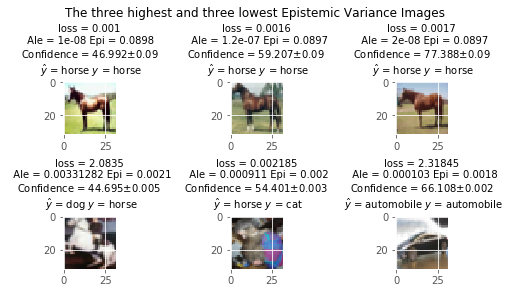

In [396]:
fig = plt.figure()
fig, axes = plt.subplots(2,3, constrained_layout=True, figsize=(7,4))
plt.suptitle('The three highest and three lowest Epistemic Variance Images')
# ax1 = fig.add_subplot(211)
# ax2 = fig.add_subplot(212)
# ax3 = fig.add_subplot(233)
# ax4 = fig.add_subplot(234)
# ax5 = fig.add_subplot(235)
# ax6 = fig.add_subplot(236)
axes[0,0].set_title('loss = ' 
                   + str(round(sort_epi.loc[index_mostepi[0]]['softmax_loss'] , 4)) 
                   + '\n'
#                    + 'uncerntainty = ' + str(round(merge_ale_epi(sort_epi.loc[index_mostepi[0]]['variance_aleatoric'],sort_epi.loc[index_mostepi[0]]['variance_epistemic']),6))
                   +' Ale = '+ str(round(sort_epi.loc[index_mostepi[0]]['variance_aleatoric'],8))
                   + ' Epi = '+ str(round(sort_epi.loc[index_mostepi[0]]['variance_epistemic'],4))
                   + '\n'
                   + 'Confidence = ' + str(round(sort_epi.loc[index_mostepi[0]]['confidence']*100,3))+'$\pm$'+str(round(sort_epi.loc[index_mostepi[0]]['confidence_error'],3))
                   + '\n'
                   + ' $\hat{y}$ = ' + str(label_con(sort_epi.loc[index_mostepi[0]]['estimated_answer']))
                   + ' $y$ = ' + str(label_con(sort_epi.loc[index_mostepi[0]]['true_answer'])), fontdict={'fontsize': 10})
         
axes[0,1].set_title('loss = ' 
                   + str(round(sort_epi.loc[index_mostepi[1]]['softmax_loss'] , 4)) 
                   + '\n'
#                    + 'uncerntainty = ' + str(round(merge_ale_epi(sort_epi.loc[index_mostepi[1]]['variance_aleatoric'],sort_epi.loc[index_mostepi[1]]['variance_epistemic']),6))

                   +'  Ale = '+ str(round(sort_epi.loc[index_mostepi[1]]['variance_aleatoric'],8))
                   + ' Epi = '+ str(round(sort_epi.loc[index_mostepi[1]]['variance_epistemic'],4))
                   + '\n'
                   + 'Confidence = ' + str(round(sort_epi.loc[index_mostepi[1]]['confidence']*100,3))+'$\pm$'+str(round(sort_epi.loc[index_mostepi[1]]['confidence_error'],3))
                   + '\n'
                   + ' $\hat{y}$ = ' + str(label_con(sort_epi.loc[index_mostepi[1]]['estimated_answer']))
                   + ' $y$ = ' + str(label_con(sort_epi.loc[index_mostepi[1]]['true_answer'])), fontdict={'fontsize': 10})
axes[0,2].set_title('loss = ' 
                   + str(round(sort_epi.loc[index_mostepi[2]]['softmax_loss'] , 4)) 
                   + '\n'
#                    + 'uncerntainty = ' + str(round(merge_ale_epi(sort_epi.loc[index_mostepi[2]]['variance_aleatoric'],sort_epi.loc[index_mostepi[2]]['variance_epistemic']),6))

                   +'  Ale = '+ str(round(sort_epi.loc[index_mostepi[2]]['variance_aleatoric'],8))
                   + ' Epi = '+ str(round(sort_epi.loc[index_mostepi[2]]['variance_epistemic'],4))
                   + '\n'
                   + 'Confidence = ' + str(round(sort_epi.loc[index_mostepi[2]]['confidence']*100,3))+'$\pm$'+str(round(sort_epi.loc[index_mostepi[2]]['confidence_error'],3))
                   + '\n'
                   + ' $\hat{y}$ = ' + str(label_con(sort_epi.loc[index_mostepi[2]]['estimated_answer']))
                   + ' $y$ = ' + str(label_con(sort_epi.loc[index_mostepi[2]]['true_answer'])), fontdict={'fontsize': 10})
axes[1,0].set_title('loss = ' 
                   + str(round(sort_epi.loc[index_mostepi[-3]]['softmax_loss'] , 4)) 
                   + '\n'
#                    + 'uncerntainty = ' + str(round(merge_ale_epi(sort_epi.loc[index_mostepi[3]]['variance_aleatoric'],sort_epi.loc[index_mostepi[3]]['variance_epistemic']),6))

                   +'  Ale = '+ str(round(sort_epi.loc[index_mostepi[-3]]['variance_aleatoric'],8))
                   + ' Epi = '+ str(round(sort_epi.loc[index_mostepi[-3]]['variance_epistemic'],4))
                   + '\n'
                   + 'Confidence = ' + str(round(sort_epi.loc[index_mostepi[-3]]['confidence']*100,3))+'$\pm$'+str(round(sort_epi.loc[index_mostepi[-3]]['confidence_error'],3))
                   + '\n'
                   + ' $\hat{y}$ = ' + str(label_con(sort_epi.loc[index_mostepi[-3]]['estimated_answer']))
                   + ' $y$ = ' + str(label_con(sort_epi.loc[index_mostepi[-3]]['true_answer'])), fontdict={'fontsize': 10})
axes[1,1].set_title('loss = ' 
                   + str(round(sort_epi.loc[index_mostepi[4]]['softmax_loss'] , 6)) 
                   + '\n'
#                    + 'uncerntainty = ' + str(round(merge_ale_epi(sort_epi.loc[index_mostepi[4]]['variance_aleatoric'],sort_epi.loc[index_mostepi[4]]['variance_epistemic']),6))

                   +'  Ale = '+ str(round(sort_epi.loc[index_mostepi[-2]]['variance_aleatoric'],6))
                   + ' Epi = '+ str(round(sort_epi.loc[index_mostepi[-2]]['variance_epistemic'],4))
                   + '\n'
                   + 'Confidence = ' + str(round(sort_epi.loc[index_mostepi[-2]]['confidence']*100,3))+'$\pm$'+str(round(sort_epi.loc[index_mostepi[-2]]['confidence_error'],3))
                   + '\n'
                   + ' $\hat{y}$ = ' + str(label_con(sort_epi.loc[index_mostepi[-2]]['estimated_answer']))
                   + ' $y$ = ' + str(label_con(sort_epi.loc[index_mostepi[-2]]['true_answer'])), fontdict={'fontsize': 10})
axes[1,2].set_title('loss = ' 
                   + str(round(sort_epi.loc[index_mostepi[-2]]['softmax_loss'] , 6)) 
                   + '\n'
#                    + 'uncerntainty = ' + str(round(merge_ale_epi(sort_epi.loc[index_mostepi[5]]['variance_aleatoric'],sort_epi.loc[index_mostepi[5]]['variance_epistemic']),6))

                   +'  Ale = '+ str(round(sort_epi.loc[index_mostepi[-1]]['variance_aleatoric'],6))
                   + ' Epi = '+ str(round(sort_epi.loc[index_mostepi[-1]]['variance_epistemic'],4))
                   + '\n'
                   + 'Confidence = ' + str(round(sort_epi.loc[index_mostepi[-1]]['confidence']*100,3))+'$\pm$'+str(round(sort_epi.loc[index_mostepi[-1]]['confidence_error'],3))
                   + '\n'
                   + ' $\hat{y}$ = ' + str(label_con(sort_epi.loc[index_mostepi[-1]]['estimated_answer']))
                   + ' $y$ = ' + str(label_con(sort_epi.loc[index_mostepi[-1]]['true_answer'])), fontdict={'fontsize': 10})


axes[0,0].imshow(X[index_mostepi[0]],interpolation='nearest')

axes[0,1].imshow(X[index_mostepi[1]],interpolation='nearest')
# set(axes[1], 'FontSize', 8)
axes[0,2].imshow(X[index_mostepi[2]],interpolation='nearest')
# set(axes[2], 'FontSize', 8)
axes[1,0].imshow(X[index_mostepi[-3]],interpolation='nearest')
# set(axes[3], 'FontSize', 8)
axes[1,1].imshow(X[index_mostepi[-2]],interpolation='nearest')
# set(axes[4], 'FontSize', 8)
axes[1,2].imshow(X[index_mostepi[-1]],interpolation='nearest')
# set(axes[5], 'FontSize', 8)
# ax3.title.set_text('Third Plot')
# ax4.title.set_text('Fourth Plot')
plt.show()
